In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


from mcp_us_airline.utils import airport_utils
from mcp_us_airline.utils import constants
from mcp_us_airline.utils import demand_utils
from mcp_us_airline.utils import io_utils
from mcp_us_airline.utils import population_utils
from mcp_us_airline.utils import preprocess_utils


/tmp/ipykernel_3163045/1351946695.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def collect_mcp_results(data):
    
    field_mappings = {
        'demand': 1,
        'supply': (0, 1),
        'seats': 2,
        'distance': 3,
        'time': 4,
        'flights': 6
    }

    # data = io_utils.read_data_file(fname)
    results = {field: [] for field in field_mappings.keys()}

    for row in tqdm(data):
        for field, idx in field_mappings.items():
                if isinstance(idx, tuple):
                    value = row[idx[0]] / row[idx[1]]
                else:
                    value = row[idx]
                results[field].append(value)
    return results

In [3]:
RAW_DIR = constants.RAW_DIR
DERIVED_DIR = constants.DERIVED_DIR
RESULTS_DIR = constants.RESULTS_DIR
ONTIME_DIR = constants.ONTIME_DIR
DB1B_DIR = constants.DB1B_DIR
POPULATION_DIR = constants.POPULATION_DIR

YEAR = 2023
MONTH = 4
DATE = [18]
CARRIER = "all"

# flights_dict = pickle.load(open(os.path.join(DERIVED_DIR, 'byproducts', f'ontime_dict_Y{YEAR}_M{MONTH}_D{DATE[0]}.pkl'), 'rb'))

In [5]:
fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', 'results_carrier_DL_gravity_B_non_coop_distance_r1.dat')
dl_nc_data = collect_mcp_results(io_utils.read_data_file(fname))

fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', 'results_carrier_DL_gravity_B_alliance_distance_r1.dat')
dl_pc_data = collect_mcp_results(io_utils.read_data_file(fname))

fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', 'results_carrier_DL_gravity_B_coop_distance_r1.dat')
dl_fc_data = collect_mcp_results(io_utils.read_data_file(fname))

fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', 'results_aircraft_fraction_0.5_gravity_B_non_coop_distance_r1.dat')
ac_nc_data = collect_mcp_results(io_utils.read_data_file(fname))

fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', 'results_aircraft_fraction_0.5_gravity_B_alliance_distance_r1.dat')
ac_pc_data = collect_mcp_results(io_utils.read_data_file(fname))

fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', 'results_aircraft_fraction_0.5_gravity_B_coop_delta30_epsilon60_distance_r1.dat')
ac_fc_data = collect_mcp_results(io_utils.read_data_file(fname))


results = {
    'delta': {
        'non_coop': dl_nc_data,
        'alliance': dl_pc_data,
        'coop': dl_fc_data,
    },
    'aircraft': {
        'non_coop': ac_nc_data,
        'alliance': ac_pc_data,
        'coop': ac_fc_data
    }
}

100%|██████████| 2263827/2263827 [00:04<00:00, 538407.62it/s]


In [6]:
def my_font_size():
    return {
        'panel_fontsize': 30,
        'main_fontsize': 25,
        'legend_fontsize': 16,
        'inset_fontsize': 16
    }

def my_line_width():
    return 3.

def my_color_dict():
    return {
        'non_coop': 'tab:blue',
        'alliance': 'tab:orange',
        'coop': 'tab:purple',
        'real_data': 'black'
    }

def my_line_style_dict():
    return {
        'non_coop': '-',
        'alliance': '--',
        'coop': ':',
        'real_data': '-.'
    }

label_mapper = {
    'non_coop': 'no cooperation',
    'alliance': 'partial cooperation',
    'coop': 'full cooperation'
}

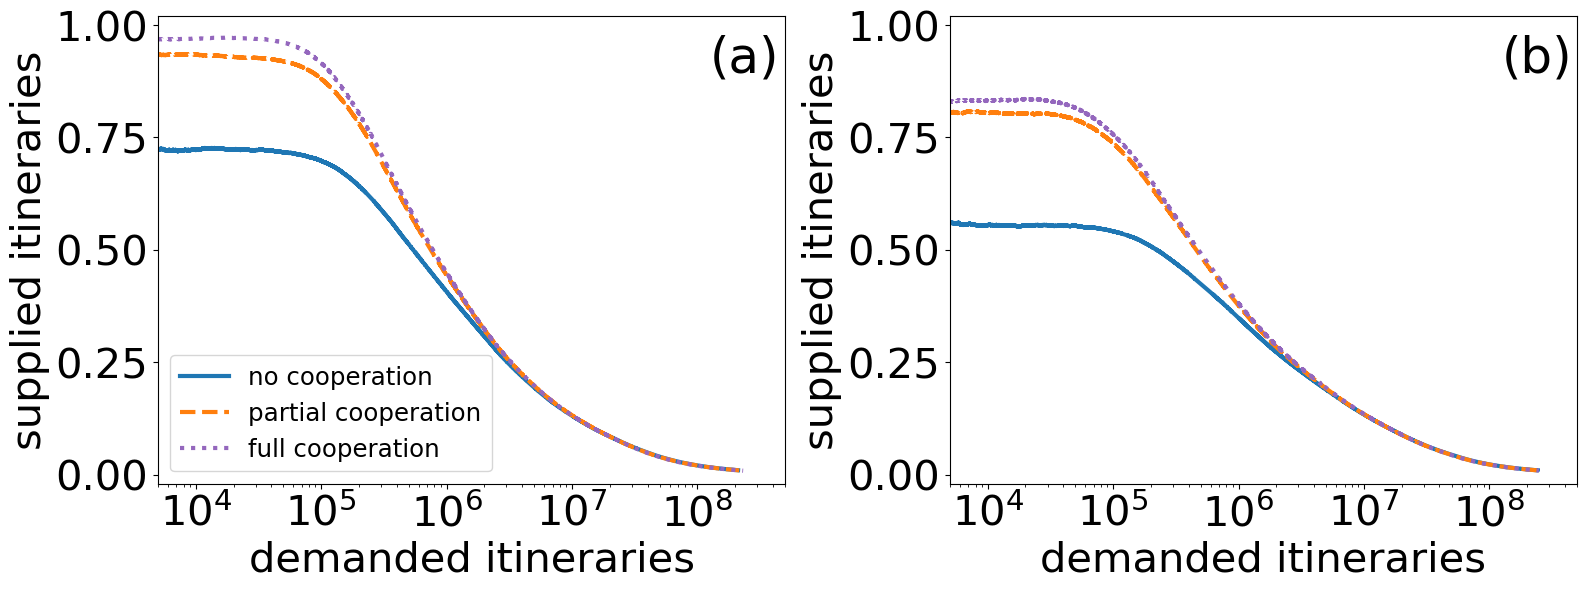

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

for coop_type in ['non_coop', 'alliance', 'coop']:
    ax[0].plot(results['delta'][coop_type]['demand'], 
               results['delta'][coop_type]['supply'], 
               ls=my_line_style_dict()[coop_type], 
               lw=my_line_width(), 
               color=my_color_dict()[coop_type], 
               label=label_mapper[coop_type])

ax[0].set_xlabel('demanded itineraries', fontsize=my_font_size()['main_fontsize']*1.2)
ax[0].set_ylabel('supplied itineraries', fontsize=my_font_size()['main_fontsize']*1.2)
ax[0].tick_params('both', labelsize=my_font_size()['main_fontsize']*1.2)
ax[0].set_xscale('log')
ax[0].set_xlim(5e3, 5e8)
ax[0].set_ylim(-0.02, 1.02)
# ax[0].tick_params('both', labelsize=my_font_size()['inset_fontsize'])
ax[0].legend(loc='lower left', 
             fontsize=my_font_size()['legend_fontsize']*1.1)


for coop_type in ['non_coop', 'alliance', 'coop']:
    ax[1].plot(results['aircraft'][coop_type]['demand'], 
               results['aircraft'][coop_type]['supply'], 
               ls=my_line_style_dict()[coop_type], 
               lw=my_line_width(), 
               color=my_color_dict()[coop_type])

ax[1].set_xlabel('demanded itineraries', fontsize=my_font_size()['main_fontsize']*1.2)
ax[1].set_ylabel('supplied itineraries', fontsize=my_font_size()['main_fontsize']*1.2)
ax[1].tick_params('both', labelsize=my_font_size()['main_fontsize']*1.2)
ax[1].set_xscale('log')
ax[1].set_xlim(5e3, 5e8)
ax[1].set_ylim(-0.02, 1.02)
# ax[1].tick_params('both', labelsize=my_font_size()['inset_fontsize'])

ax[0].text(0.88, 0.88, '(a)', transform=ax[0].transAxes, 
           fontsize=my_font_size()['panel_fontsize']*1.2)

ax[1].text(0.88, 0.88, '(b)', transform=ax[1].transAxes, 
           fontsize=my_font_size()['panel_fontsize']*1.2)



plt.tight_layout()
plt.savefig(os.path.join('../results/manuscript/figure5.pdf'), bbox_inches='tight', format='pdf')
plt.show()
